In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from matplotlib import pyplot as plt
import nltk
import random

import seaborn as sns
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pprint, time


/Users/he/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/Users/he/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidanc

In [2]:
nltk.download("treebank")
nltk.download("universal_tagset")
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset="universal"))
#print(nltk_data)[:2]

[nltk_data] Downloading package treebank to /Users/he/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/he/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [3]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in nltk_data:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [4]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [5]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 3914
Vocabulary size: 11387
Total number of tags: 12


In [6]:
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



In [7]:
word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [8]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [9]:
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3] 

Y:  [1, 1, 3, 8, 1, 7, 3, 2, 2, 5, 1, 4, 5, 7, 1, 1, 8, 3] 



In [10]:
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


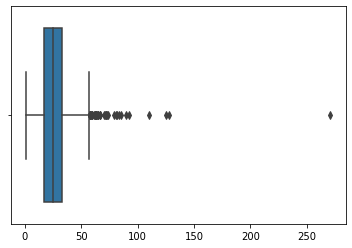

In [11]:
sns.boxplot(lengths)
plt.show()

In [12]:
MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated
start=time.time()
X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
#print(X_padded[0], "\n"*3)
#print(Y_padded[0])

In [13]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

In [14]:
path = '../POS_tagging/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [15]:
word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"])

[('Queen', 0.4929387867450714),
 ('Tupou_V.', 0.45174285769462585),
 ('Oprah_BFF_Gayle', 0.4422132968902588),
 ('Jackson', 0.440250426530838),
 ('NECN_Alison', 0.4331282675266266),
 ('Whitfield', 0.42834725975990295),
 ('Ida_Vandross', 0.42084527015686035),
 ('prosecutor_Dan_Satterberg', 0.420758992433548),
 ('martin_Luther_King', 0.42059651017189026),
 ('Coretta_King', 0.4202733635902405)]

In [16]:
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [17]:
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (11388, 300)


In [18]:
# example of word embedding results
embedding_weights[word_tokenizer.word_index['eat']]

array([-1.57226562e-01, -1.07421875e-01, -3.14941406e-02,  4.78515625e-01,
       -2.05078125e-01,  1.65039062e-01,  2.00195312e-01,  8.60595703e-03,
       -1.19140625e-01,  2.34375000e-01, -2.09960938e-02, -8.54492188e-02,
       -5.51757812e-02,  1.44531250e-01, -1.84570312e-01,  2.20703125e-01,
       -6.10351562e-03,  1.04003906e-01,  3.63769531e-02, -1.85546875e-02,
       -8.59375000e-02,  5.54199219e-02,  2.81250000e-01,  1.96289062e-01,
       -7.91015625e-02, -2.73437500e-01, -3.83300781e-02, -7.22656250e-02,
       -1.12304688e-01,  3.50952148e-03, -6.78710938e-02,  2.37304688e-01,
       -8.78906250e-02, -1.41601562e-01, -4.78515625e-02, -1.78710938e-01,
        1.46484375e-01, -1.25000000e-01, -5.83496094e-02,  2.48046875e-01,
       -2.06298828e-02, -2.20703125e-01,  1.87500000e-01,  1.39648438e-01,
        3.24707031e-02, -1.91650391e-02, -1.54296875e-01, -5.54199219e-02,
       -2.05078125e-01,  1.03515625e-01, -1.10351562e-01, -5.54199219e-02,
        3.29589844e-02, -

In [19]:
Y = to_categorical(Y)
print(Y.shape)

(3914, 100, 13)


In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=121)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=121)

In [21]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))


TRAINING DATA
Shape of input sequences: (2504, 100)
Shape of output sequences: (2504, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (627, 100)
Shape of output sequences: (627, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (783, 100)
Shape of output sequences: (783, 100, 13)


In [22]:
NUM_CLASSES = Y.shape[2]
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [23]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])
end=time.time()
diff=end-start
print(diff)

111.18782711029053


In [24]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          3416400   
                                                                 
 lstm (LSTM)                 (None, 100, 64)           93440     
                                                                 
 time_distributed (TimeDistr  (None, 100, 13)          845       
 ibuted)                                                         
                                                                 
Total params: 3,510,685
Trainable params: 3,510,685
Non-trainable params: 0
_________________________________________________________________


In [25]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
20/20 [==============================] - 10s 315ms/step - loss: 1.8634 - acc: 0.7834 - val_loss: 0.9519 - val_acc: 0.7623
Epoch 2/10
20/20 [==============================] - 6s 289ms/step - loss: 0.7552 - acc: 0.7964 - val_loss: 0.6401 - val_acc: 0.8132
Epoch 3/10
20/20 [==============================] - 6s 284ms/step - loss: 0.6081 - acc: 0.8105 - val_loss: 0.5687 - val_acc: 0.8163
Epoch 4/10
20/20 [==============================] - 6s 301ms/step - loss: 0.5574 - acc: 0.8144 - val_loss: 0.5245 - val_acc: 0.8223
Epoch 5/10
20/20 [==============================] - 6s 306ms/step - loss: 0.5075 - acc: 0.8279 - val_loss: 0.4712 - val_acc: 0.8438
Epoch 6/10
20/20 [==============================] - 7s 369ms/step - loss: 0.4491 - acc: 0.8558 - val_loss: 0.4105 - val_acc: 0.8742
Epoch 7/10
20/20 [==============================] - 7s 361ms/step - loss: 0.3804 - acc: 0.8935 - val_loss: 0.3398 - val_acc: 0.9188
Epoch 8/10
20/20 [==============================] - 5s 261ms/step - loss: 0

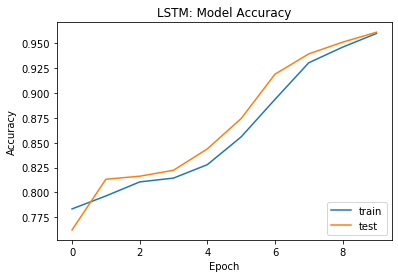

In [26]:
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('LSTM: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [27]:
lstm_model.evaluate(X_test,Y_test)

25/25 [==============================] - 1s 26ms/step - loss: 0.1721 - acc: 0.9587


[0.17206509411334991, 0.9586973190307617]

In [28]:
bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim = VOCABULARY_SIZE,
 output_dim = EMBEDDING_SIZE,
 input_length = MAX_SEQ_LENGTH,
 weights = [embedding_weights],
 trainable = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
# check summary of model
bidirect_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          3416400   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         186880    
 l)                                                              
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 3,604,957
Trainable params: 3,604,957
Non-trainable params: 0
_________________________________________________________________


In [29]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
20/20 [==============================] - 15s 494ms/step - loss: 1.6713 - acc: 0.7597 - val_loss: 0.6462 - val_acc: 0.7913
Epoch 2/10
20/20 [==============================] - 8s 416ms/step - loss: 0.6085 - acc: 0.8105 - val_loss: 0.5564 - val_acc: 0.8152
Epoch 3/10
20/20 [==============================] - 9s 464ms/step - loss: 0.5430 - acc: 0.8145 - val_loss: 0.5076 - val_acc: 0.8285
Epoch 4/10
20/20 [==============================] - 10s 498ms/step - loss: 0.4919 - acc: 0.8359 - val_loss: 0.4517 - val_acc: 0.8508
Epoch 5/10
20/20 [==============================] - 11s 566ms/step - loss: 0.4241 - acc: 0.8708 - val_loss: 0.3746 - val_acc: 0.8999
Epoch 6/10
20/20 [==============================] - 11s 529ms/step - loss: 0.3344 - acc: 0.9171 - val_loss: 0.2804 - val_acc: 0.9324
Epoch 7/10
20/20 [==============================] - 9s 448ms/step - loss: 0.2359 - acc: 0.9425 - val_loss: 0.1919 - val_acc: 0.9516
Epoch 8/10
20/20 [==============================] - 9s 475ms/step - loss

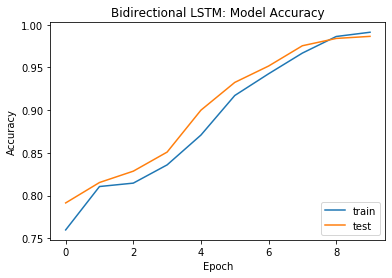

In [30]:
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('Bidirectional LSTM: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [31]:
bidirect_model.evaluate(X_test,Y_test)

25/25 [==============================] - 1s 44ms/step - loss: 0.0686 - acc: 0.9853


[0.06862455606460571, 0.9853384494781494]